# Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import copy
import functools
import gc
import itertools
import logging
import operator
import os
import pathlib
import re
import socket
import sys
import time
from collections import Counter
from dataclasses import asdict, dataclass, field
from enum import Enum
from functools import partial
from pathlib import Path
from pprint import PrettyPrinter, pprint
from typing import *

In [3]:
%autoreload 2

import humanize
import matplotlib
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import yaml
from matplotlib import cm, patches, pyplot as plt
from numpy import ndarray
from numpy.random import RandomState
from progressbar import progressbar as pbar
from pymicro.file import file_utils
from sklearn import metrics, metrics as met, model_selection, preprocessing
from tensorflow import keras
from tensorflow.keras import (
    callbacks as keras_callbacks,
    layers,
    losses,
    metrics as keras_metrics,
    optimizers,
    utils,
)
from tqdm import tqdm
from yaml import YAMLObject

In [6]:
%autoreload 2

from tomo2seg import (
    callbacks as tomo2seg_callbacks,
    data as tomo2seg_data,
    losses as tomo2seg_losses,
    schedule as tomo2seg_schedule,
    slack,
    slackme,
    utils as tomo2seg_utils,
    viz as tomo2seg_viz,
    volume_sequence,
)
from tomo2seg.data import EstimationVolume, Volume
from tomo2seg.logger import add_file_handler, dict2str, logger
from tomo2seg.model import Model as Tomo2SegModel

In [7]:
# this registers a custom exception handler for the whole current notebook
get_ipython().set_custom_exc((Exception,), slackme.custom_exc)

# Args

In [8]:
# [manual-input]
from tomo2seg.datasets import (
    VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
    #     VOLUME_COMPOSITE_V1_REDUCED as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_LABELS_REFINED3 as LABELS_VERSION,
)

volume_name, volume_version = VOLUME_NAME_VERSION
labels_version = LABELS_VERSION

random_state_seed = 42
runid = int(time.time())
# runid = 1607944057

# None == all
partitions_to_compute_aliases = None

logger.info(f"{volume_name=}")
logger.info(f"{volume_version=}")
logger.info(f"{labels_version=}")
logger.info(f"{partitions_to_compute_aliases=}")

INFO::tomo2seg::{<ipython-input-8-9da9c74e71cf>:<module>:018}::[2020-12-14::15:24:22.450]
volume_name='PA66GF30'

INFO::tomo2seg::{<ipython-input-8-9da9c74e71cf>:<module>:019}::[2020-12-14::15:24:22.452]
volume_version='v1'

INFO::tomo2seg::{<ipython-input-8-9da9c74e71cf>:<module>:020}::[2020-12-14::15:24:22.454]
labels_version='refined3'

INFO::tomo2seg::{<ipython-input-8-9da9c74e71cf>:<module>:021}::[2020-12-14::15:24:22.455]
partitions_to_compute_aliases=None



# Setup

In [9]:
logger.setLevel(logging.DEBUG)
random_state = np.random.RandomState(random_state_seed)

In [10]:
volume = Volume.with_check(
    name=volume_name, version=volume_version
)

logger.debug(f"volum=\n{dict2str(asdict(volume))}")

volume_partitions_aliases = tuple(volume.metadata.set_partitions.keys())

if partitions_to_compute_aliases is None:

    logger.info("Using all available parittions.")
    
    partitions_to_compute_aliases = volume_partitions_aliases

else:
    assert len(partitions_to_compute_aliases) >= 0
    
    for part_alias in partitions_to_compute_aliases:

        try:
            volume[part_alias]

        except KeyError as ex:
            logger.exception(ex)
            raise ValueError(f"Invalid volume partition. {volume.fullname=} {volume_partitions_aliases=} {partitions_to_compute_aliases=}")

logger.info(f"{partitions_to_compute_aliases=}")

DEBUG::tomo2seg::{data.py:with_check:244}::[2020-12-14::15:24:39.108]
vol=Volume(name='PA66GF30', version='v1', _metadata=None)

DEBUG::tomo2seg::{data.py:metadata:180}::[2020-12-14::15:24:39.110]
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

DEBUG::tomo2seg::{<ipython-input-10-049f5d8a27da>:<module>:005}::[2020-12-14::15:24:39.120]
volum=
{   '_metadata': {   'dimensions': [1300, 1040, 1900],
                     'dtype': 'uint8',
                     'labels': [0, 1, 2],
                     'labels_names': {0: 'matrix', 1: 'fiber', 2: 'porosity'},
                     'set_partitions': {   'test': {   'alias': 'test',
                                                       'x_range': [0, 1300],
                                                       'y_range': [0, 1040],
                                                       'z_range': [1300, 1600]},
                                           'train': {   'alias': 'train'

In [22]:
exec_name = f"{volume.fullname}.ground-truth-analysis.runid={tomo2seg_utils.fmt_runid(runid)}"
exec_dir = volume.dir / exec_name
figs_dir = exec_dir

logger.info(f"{exec_name=}")
logger.info(f"{exec_dir=}")

exec_dir.mkdir(exist_ok=True)

INFO::tomo2seg::{<ipython-input-22-35ea6f48e9b3>:<module>:005}::[2020-12-14::15:30:38.212]
exec_name='PA66GF30.v1.ground-truth-analysis.runid=1607-944-057'

INFO::tomo2seg::{<ipython-input-22-35ea6f48e9b3>:<module>:006}::[2020-12-14::15:30:38.214]
exec_dir=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.ground-truth-analysis.runid=1607-944-057')



# Load data

In [23]:
logger.info("Loading data from disk.")

data_volume = file_utils.HST_read(
    str(volume.data_path),  # it doesn't accept paths...
    
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=volume.metadata.dtype,
    dims=volume.metadata.dimensions,
    verbose=False,
)

logger.debug(f"{data_volume.shape=}")

logger.info("Loading labels from disk.")

labels_volume = file_utils.HST_read(
    str(volume.versioned_labels_path(labels_version)),  # it doesn't accept paths...
    
    autoparse_filename=False,  # the file names are not properly formatted
    data_type="uint8",
    dims=volume.metadata.dimensions,
    verbose=False,
)

logger.debug(f"{labels_volume.shape=}")

def iterate_partitions() -> Tuple[ndarray, ndarray]:
    """avoid loading all the partitions one by one (more memory)"""
    for partition_alias in partitions_to_compute_aliases:
        yield (
            partition_alias,
            volume[partition_alias].get_volume_partition(data_volume),
            volume[partition_alias].get_volume_partition(labels_volume),
        )

INFO::tomo2seg::{<ipython-input-23-2d7919941288>:<module>:001}::[2020-12-14::15:30:39.700]
Loading data from disk.

DEBUG::tomo2seg::{<ipython-input-23-2d7919941288>:<module>:012}::[2020-12-14::15:30:42.996]
data_volume.shape=(1300, 1040, 1900)

INFO::tomo2seg::{<ipython-input-23-2d7919941288>:<module>:014}::[2020-12-14::15:30:42.998]
Loading labels from disk.

DEBUG::tomo2seg::{<ipython-input-23-2d7919941288>:<module>:025}::[2020-12-14::15:30:46.111]
labels_volume.shape=(1300, 1040, 1900)



# Useful variables

In [24]:
labels_idx = volume.metadata.labels
labels_names = [volume.metadata.labels_names[idx] for idx in labels_idx]

labels_idx_name = list(zip(labels_idx, labels_names))

n_classes = len(labels_idx)

logger.debug(f"{n_classes=}")
logger.debug(f"{labels_idx=}")
logger.debug(f"{labels_names=}")

DEBUG::tomo2seg::{<ipython-input-24-e660959e547d>:<module>:008}::[2020-12-14::15:30:46.165]
n_classes=3

DEBUG::tomo2seg::{<ipython-input-24-e660959e547d>:<module>:009}::[2020-12-14::15:30:46.167]
labels_idx=[0, 1, 2]

DEBUG::tomo2seg::{<ipython-input-24-e660959e547d>:<module>:010}::[2020-12-14::15:30:46.167]
labels_names=['matrix', 'fiber', 'porosity']



# [compute] value histogram per label

In [30]:
MAX_BIN_EDGE = {
    "uint8": 256,
    "uint16": 65536,
}

max_bin_edge = MAX_BIN_EDGE[volume.metadata.dtype]

logger.debug(f"{max_bin_edge=}")

n_bins = 256

logger.debug(f"{n_bins=}")

hist_bin_edges = np.linspace(0, max_bin_edge, n_bins + 1).astype(int)

def get_hist_per_label(data_seq, labels_seq):
    
    assert (tensor_order := len(data_seq.shape)) == 1, f"{tensor_order}"
    
    data_hists_per_label = np.zeros((n_classes, n_bins), dtype=np.int64) # int64 is important to not overflow

    for label_idx in labels_idx:

        logger.debug(f"Computing histogram for {label_idx=}")

        data_hists_per_label[label_idx], bins = np.histogram(
            data_seq[labels_seq == label_idx],
            bins=hist_bin_edges,
            density=False,
        )
        
    return data_hists_per_label

logger.info(f"Computing value histograms per label on the partitions.")
hists_per_label = {
    partition_alias: get_hist_per_label(part_data.ravel(), part_labels.ravel())
    for partition_alias, part_data, part_labels in iterate_partitions()
}

logger.info(f"Computing value histograms per label on the whole volume.")
hists_per_label[None] = get_hist_per_label(
    data_volume.ravel(),
    labels_volume.ravel(),
)

DEBUG::tomo2seg::{<ipython-input-30-487767a18070>:<module>:008}::[2020-12-14::15:34:43.212]
max_bin_edge=256

DEBUG::tomo2seg::{<ipython-input-30-487767a18070>:<module>:012}::[2020-12-14::15:34:43.214]
n_bins=256

INFO::tomo2seg::{<ipython-input-30-487767a18070>:<module>:034}::[2020-12-14::15:34:43.216]
Computing value histograms per label on the partitions.

DEBUG::tomo2seg::{<ipython-input-30-487767a18070>:get_hist_per_label:024}::[2020-12-14::15:35:20.360]
Computing histogram for label_idx=0

DEBUG::tomo2seg::{<ipython-input-30-487767a18070>:get_hist_per_label:024}::[2020-12-14::15:36:24.739]
Computing histogram for label_idx=1

DEBUG::tomo2seg::{<ipython-input-30-487767a18070>:get_hist_per_label:024}::[2020-12-14::15:36:40.919]
Computing histogram for label_idx=2

DEBUG::tomo2seg::{<ipython-input-30-487767a18070>:get_hist_per_label:024}::[2020-12-14::15:36:47.868]
Computing histogram for label_idx=0

DEBUG::tomo2seg::{<ipython-input-30-487767a18070>:get_hist_per_label:024}::[2020-1

# [save] value histogram per label

In [32]:
def get_filename_value_hist_per_label(partition_: str) -> Path:
    fname = f"value-histogram-per-label"
    fname += f".partition={partition_}" if partition_ is not None else ""
    fname += ".npy"
    return fname

logger.info(f"Saving value histogram per label for all partitions and the whole volume.")

for partition_alias, histogram_per_label in hists_per_label.items():
    
    filename = get_filename_value_hist_per_label(partition_alias)
    
    logger.debug(f"Saving {partition_alias=} ==> {filename=}")
    
    filepath = exec_dir / filename
    
    logger.debug(f"{filepath=}")

    np.save(
        file=filepath,
        arr=histogram_per_label,
    )

INFO::tomo2seg::{<ipython-input-32-24fd24e9be29>:<module>:007}::[2020-12-14::15:40:24.862]
Saving value histogram per label for all partitions and the whole volume.

DEBUG::tomo2seg::{<ipython-input-32-24fd24e9be29>:<module>:013}::[2020-12-14::15:40:24.863]
Saving partition_alias='train' ==> filename='value-histogram-per-label.partition=train.npy'

DEBUG::tomo2seg::{<ipython-input-32-24fd24e9be29>:<module>:017}::[2020-12-14::15:40:24.864]
filepath=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.ground-truth-analysis.runid=1607-944-057/value-histogram-per-label.partition=train.npy')

DEBUG::tomo2seg::{<ipython-input-32-24fd24e9be29>:<module>:013}::[2020-12-14::15:40:24.900]
Saving partition_alias='val' ==> filename='value-histogram-per-label.partition=val.npy'

DEBUG::tomo2seg::{<ipython-input-32-24fd24e9be29>:<module>:017}::[2020-12-14::15:40:24.901]
filepath=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.ground-truth

In [33]:
del data_volume, labels_volume

In [34]:
gc.collect()

4438

In [40]:
logger.info("Saving bins.")

hist_bins = hist_bin_edges[:-1]

filename = exec_dir / "value-histogram-per-label.bins.npy"

logger.debug(f"{filename=}")
    
filepath = exec_dir / filename

logger.debug(f"{filepath=}")

np.save(
    file=filepath,
    arr=hist_bins,
)

INFO::tomo2seg::{<ipython-input-40-dcab2d13ea1b>:<module>:001}::[2020-12-14::15:42:36.828]
Saving bins.

DEBUG::tomo2seg::{<ipython-input-40-dcab2d13ea1b>:<module>:007}::[2020-12-14::15:42:36.830]
filename=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.ground-truth-analysis.runid=1607-944-057/value-histogram-per-label.bins.npy')

DEBUG::tomo2seg::{<ipython-input-40-dcab2d13ea1b>:<module>:011}::[2020-12-14::15:42:36.831]
filepath=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.ground-truth-analysis.runid=1607-944-057/value-histogram-per-label.bins.npy')



# derived computations

## class imbalance

In [42]:
class_imbalance = {
    partition_alias: part_hist_per_label.sum(axis=1) 
    for partition_alias, part_hist_per_label in hists_per_label.items()
}

## value histograms

In [36]:
hists = {
    partition_alias: part_hist_per_label.sum(axis=0) 
    for partition_alias, part_hist_per_label in hists_per_label.items()
}

hists_norm = {
    partition_alias: part_hist / part_hist.sum() 
    for partition_alias, part_hist in hists.items()
}

## value histograms NORMED per label 

In [76]:
hists_per_label_norm = {
    partition_alias: part_hist / part_hist.sum(axis=1, keepdims=True)
    for partition_alias, part_hist in hists_per_label.items()
}

## value histograms per label GLOBAL NORMED

In [77]:
hists_per_label_global_norm = {
    partition_alias: part_hist / part_hist.sum() 
    for partition_alias, part_hist in hists_per_label.items()
}

# plots

In [89]:
def get_line_label_simple(label_idx):
    return labels_names[label_idx]

def get_line_label_with_nvoxels(label_idx):
    return f"{labels_names[label_idx]} (nvoxels: {humanize.intcomma(class_imb[label_idx])})"

## class imbalance

INFO::tomo2seg::{viz.py:plot:757}::[2020-12-14::15:44:32.272]
The minimum accuracy is: random_model_accu=82.37%

INFO::tomo2seg::{<ipython-input-44-5b96753e0ef7>:<module>:012}::[2020-12-14::15:44:32.273]
Saving figure (figname := display.title + '.png')='PA66GF30.v1  --  partition=train.class-imbalance.png'

INFO::tomo2seg::{viz.py:plot:757}::[2020-12-14::15:44:32.421]
The minimum accuracy is: random_model_accu=81.94%

INFO::tomo2seg::{<ipython-input-44-5b96753e0ef7>:<module>:012}::[2020-12-14::15:44:32.423]
Saving figure (figname := display.title + '.png')='PA66GF30.v1  --  partition=val.class-imbalance.png'

INFO::tomo2seg::{viz.py:plot:757}::[2020-12-14::15:44:32.525]
The minimum accuracy is: random_model_accu=82.44%

INFO::tomo2seg::{<ipython-input-44-5b96753e0ef7>:<module>:012}::[2020-12-14::15:44:32.527]
Saving figure (figname := display.title + '.png')='PA66GF30.v1  --  partition=test.class-imbalance.png'

INFO::tomo2seg::{viz.py:plot:757}::[2020-12-14::15:44:32.623]
The minimum

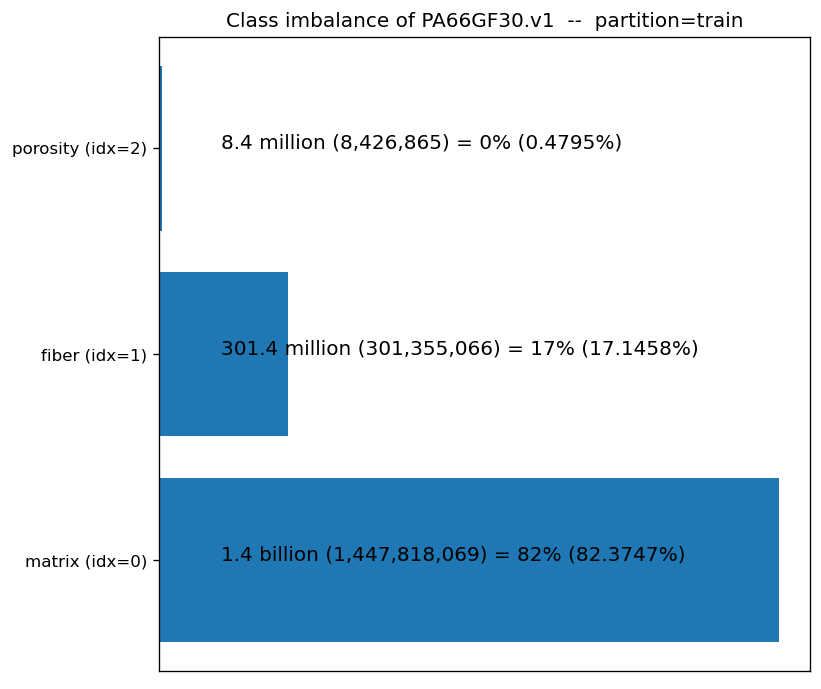

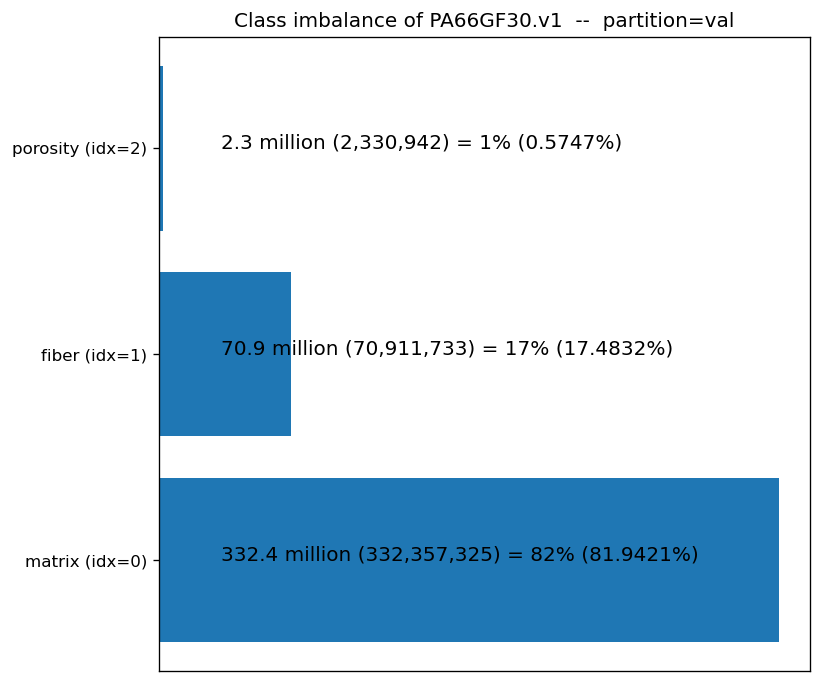

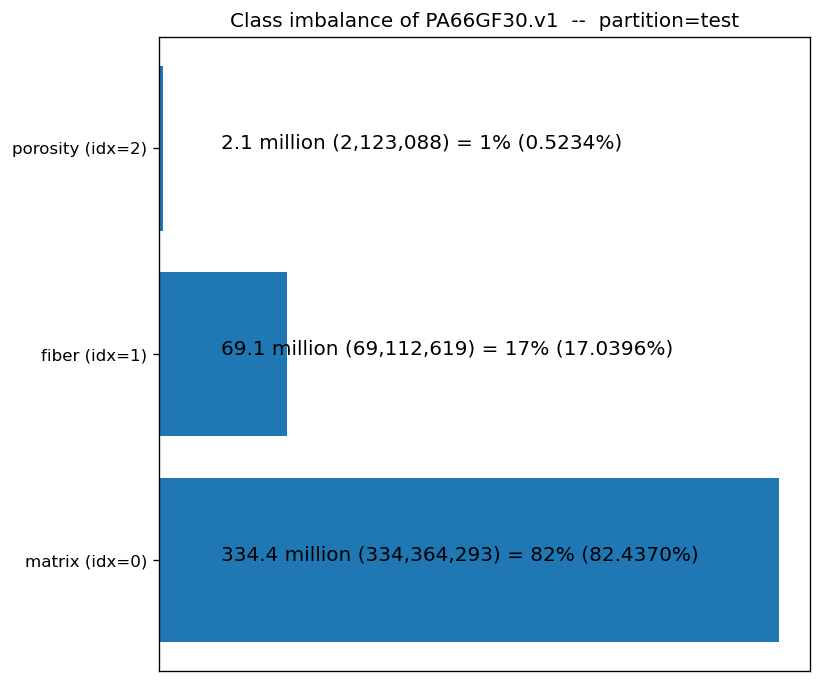

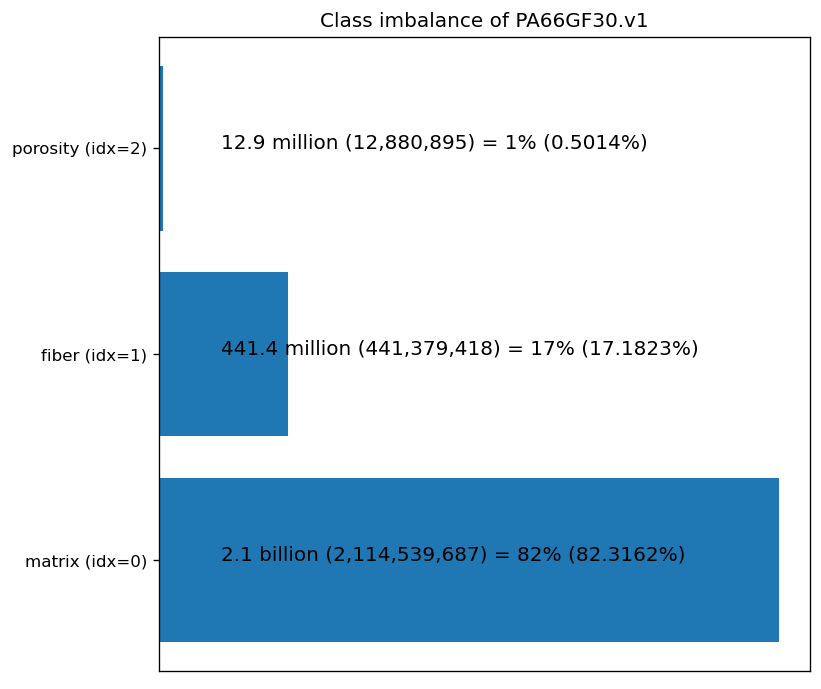

In [44]:
for partition_alias, class_imb in class_imbalance.items():

    fig, ax = plt.subplots(1, 1, figsize=(sz := 7, sz), dpi=(dpi := 120))

    display = viz.ClassImbalanceDisplay(
        volume_name=f"{volume.fullname}" + ("" if partition_alias is None else f"  --  partition={partition_alias}"),
        labels_idx=labels_idx,
        labels_names=labels_names,
        labels_counts=class_imb,
    ).plot(ax)

    logger.info(f"Saving figure {(figname := display.title + '.png')=}")
    
    display.fig_.savefig(
        fname=figs_dir / figname,
        format="png",
        metadata=display.metadata,
    )

## value histogram

INFO::tomo2seg::{<ipython-input-78-40010b88ed7a>:<module>:012}::[2020-12-14::16:02:56.112]
Saving figure (figname := display.title + '.png')='PA66GF30.v1  --  partition=train.voxel-value-histogram.png'



/home/users/jcasagrande/projects/tomo2seg/tomo2seg/viz.py:816: UserWarning: FixedFormatter should only be used together with FixedLocator
  axlog.set_yticklabels(


INFO::tomo2seg::{<ipython-input-78-40010b88ed7a>:<module>:012}::[2020-12-14::16:02:56.557]
Saving figure (figname := display.title + '.png')='PA66GF30.v1  --  partition=val.voxel-value-histogram.png'

INFO::tomo2seg::{<ipython-input-78-40010b88ed7a>:<module>:012}::[2020-12-14::16:02:56.994]
Saving figure (figname := display.title + '.png')='PA66GF30.v1  --  partition=test.voxel-value-histogram.png'

INFO::tomo2seg::{<ipython-input-78-40010b88ed7a>:<module>:012}::[2020-12-14::16:02:57.353]
Saving figure (figname := display.title + '.png')='PA66GF30.v1.voxel-value-histogram.png'



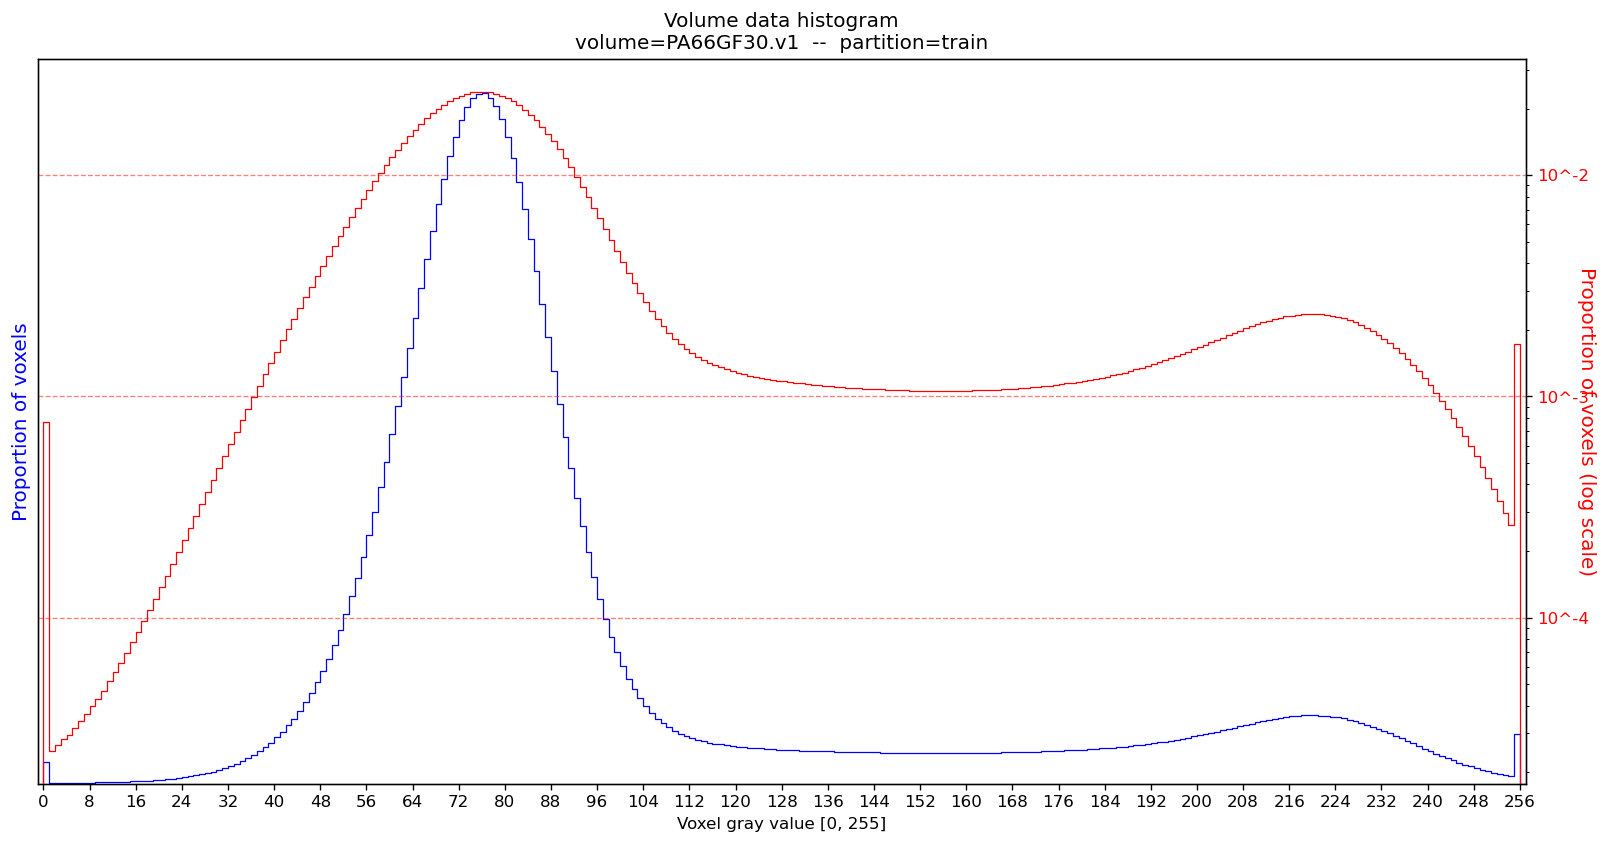

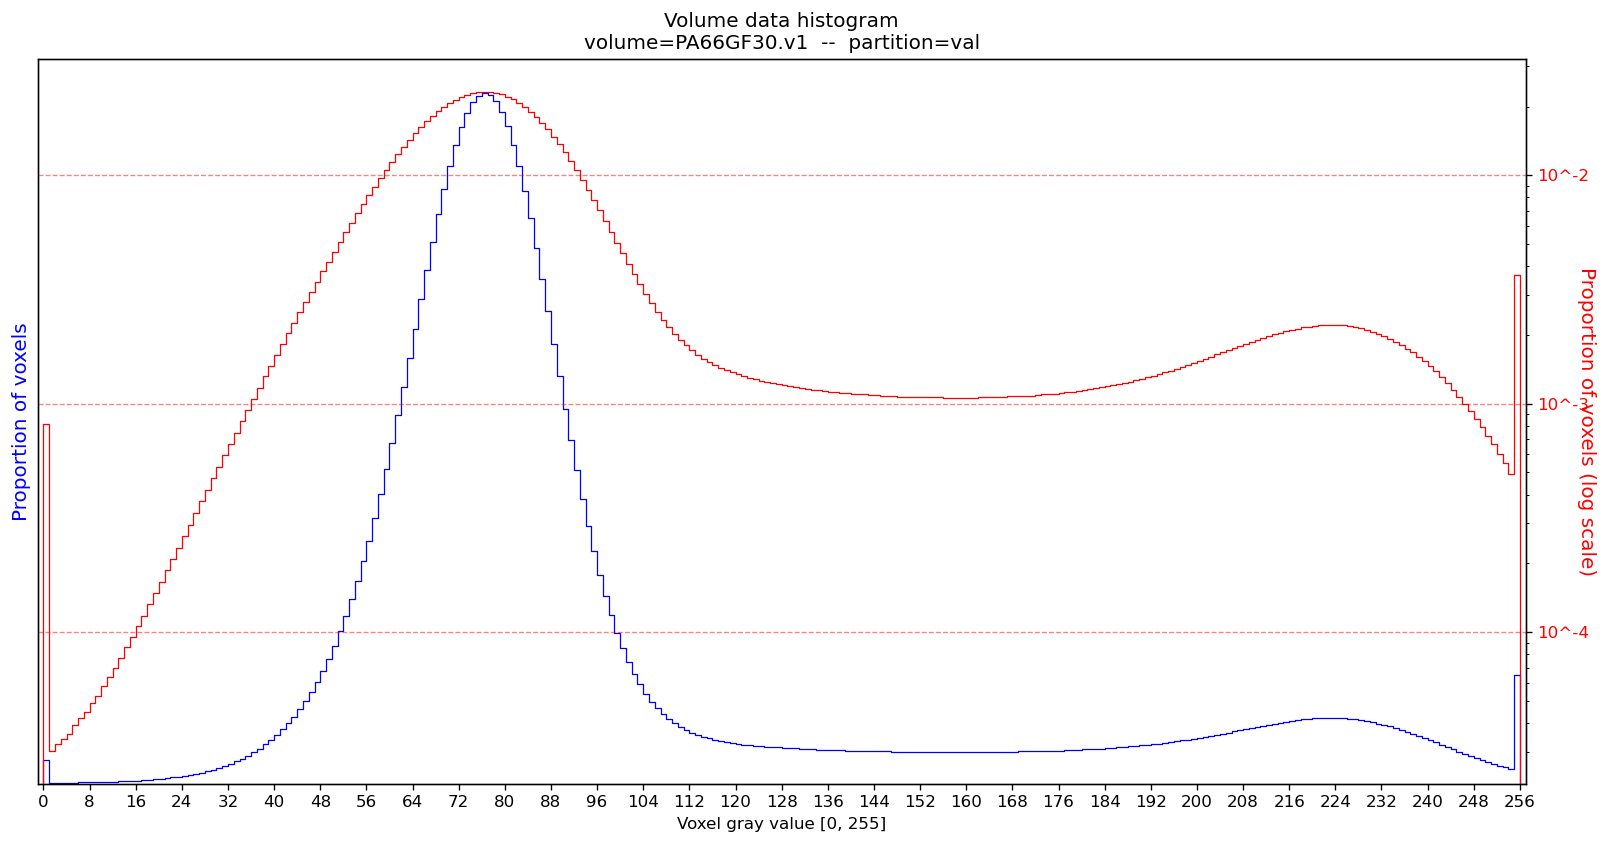

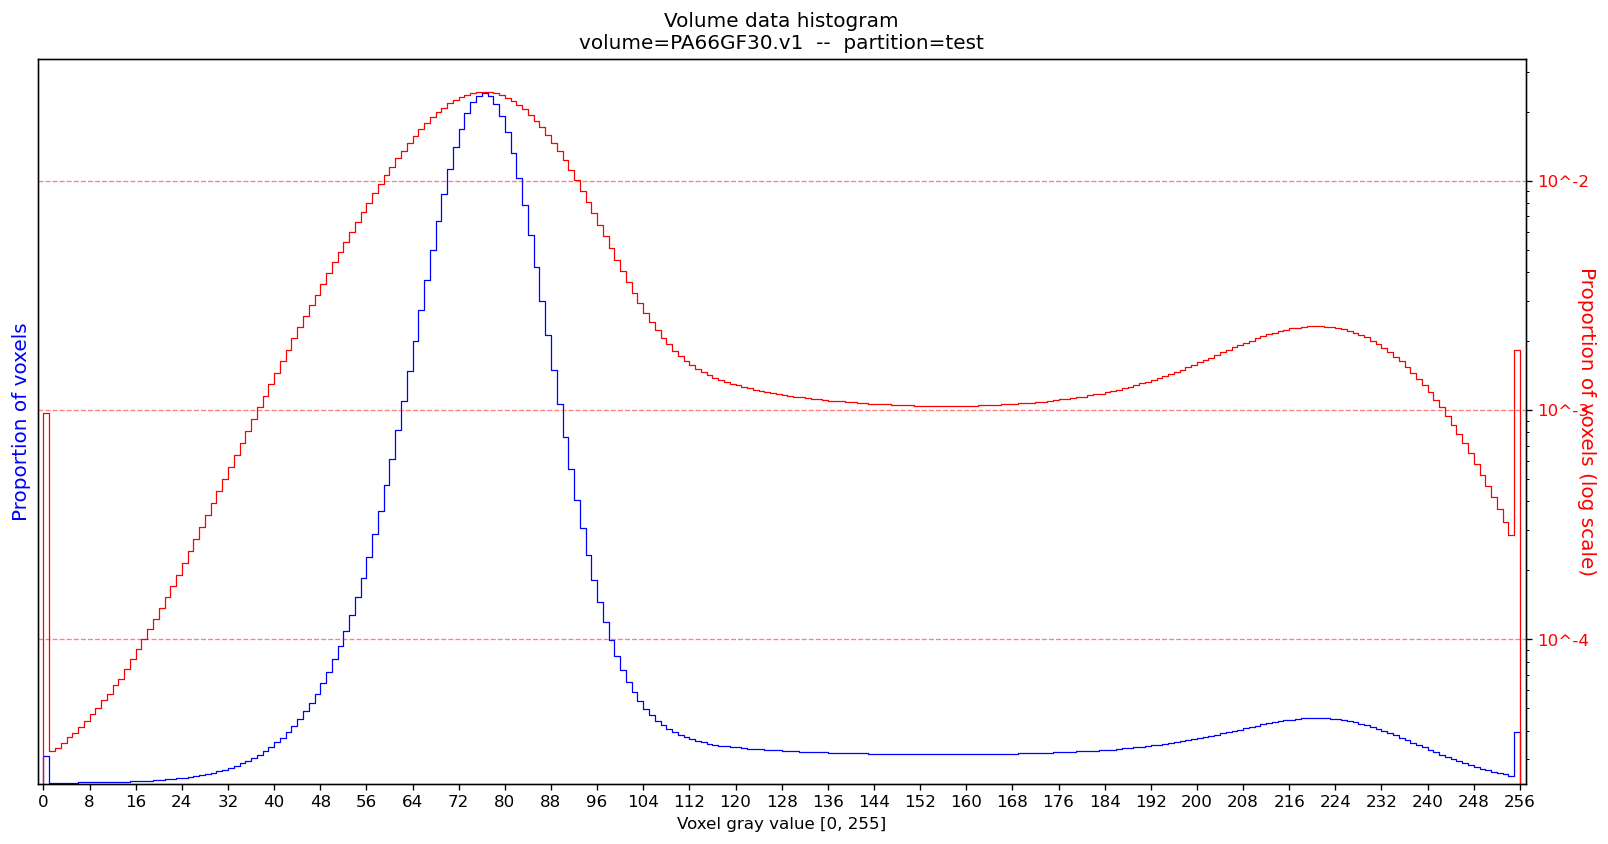

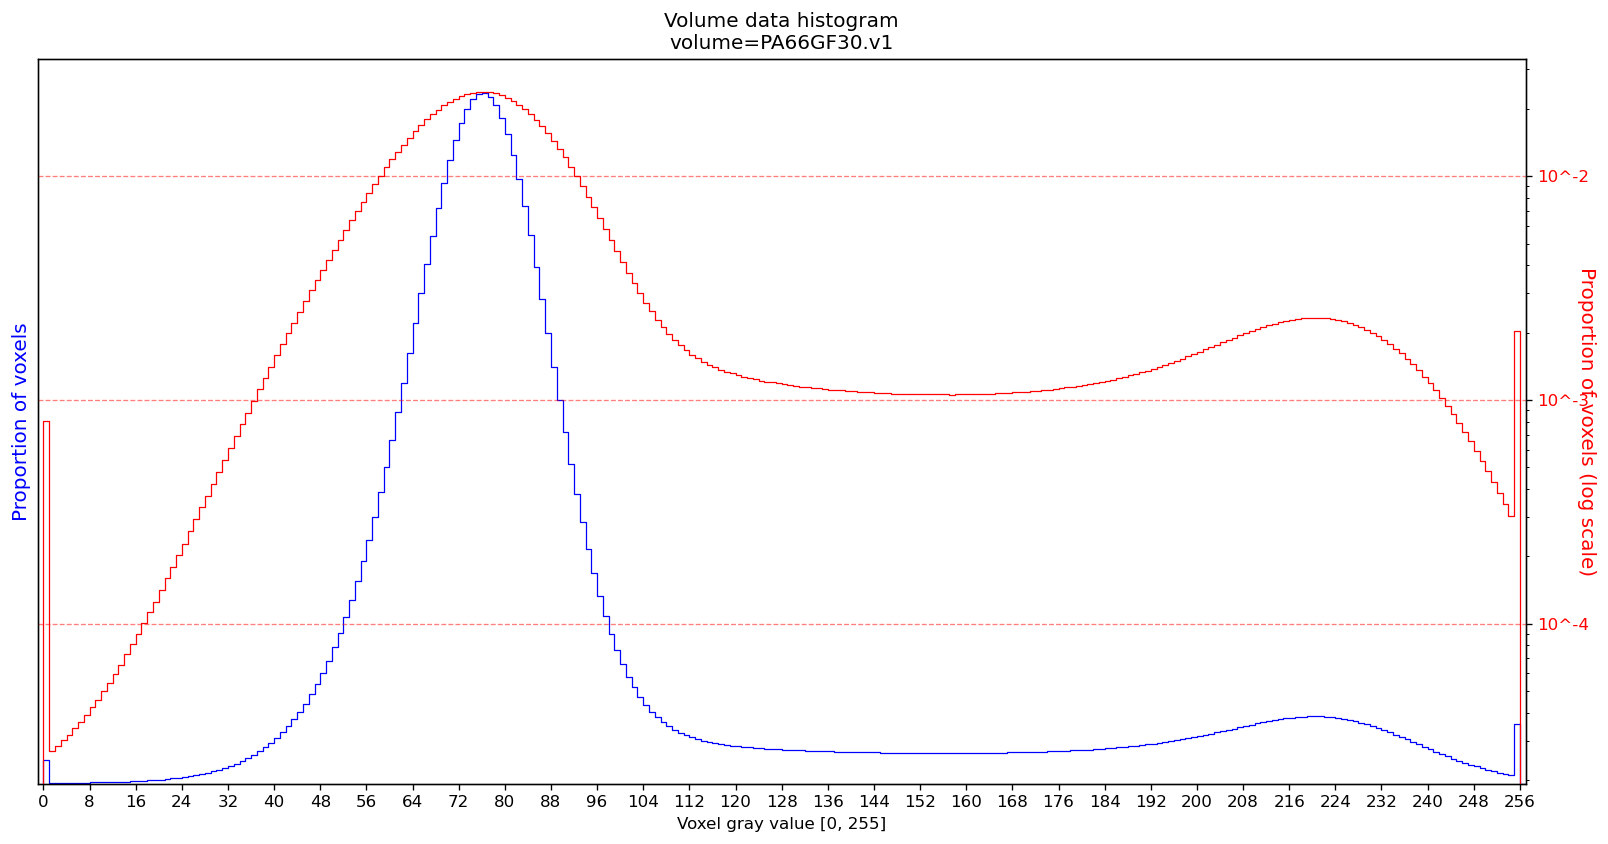

In [78]:
for partition_alias, hist_ in hists_norm.items():

    fig, ax = plt.subplots(1, 1, figsize=(2 * (sz := 8), sz), dpi=(dpi := 120))

    # i want to get the vertical borders to show up
    display = viz.VoxelValueHistogramDisplay(
        volume_name=f"{volume.fullname}" + ("" if partition_alias is None else f"  --  partition={partition_alias}"),
        bins=hist_bins.tolist(),
        values=hist_.tolist(),
    ).plot(ax)

    logger.info(f"Saving figure {(figname := display.title + '.png')=}")
    
    display.fig_.savefig(
        fname=figs_dir / figname,
        format="png",
        metadata=display.metadata,
    )

## value histogram per label

INFO::tomo2seg::{<ipython-input-94-d706558723f7>:<module>:028}::[2020-12-14::16:20:12.222]
Saving figure (figname := display.title + '.png')='PA66GF30.v1  --  partition=train.data-histogram-per-label.png'

INFO::tomo2seg::{<ipython-input-94-d706558723f7>:<module>:028}::[2020-12-14::16:20:12.938]
Saving figure (figname := display.title + '.png')='PA66GF30.v1  --  partition=val.data-histogram-per-label.png'

INFO::tomo2seg::{<ipython-input-94-d706558723f7>:<module>:028}::[2020-12-14::16:20:13.630]
Saving figure (figname := display.title + '.png')='PA66GF30.v1  --  partition=test.data-histogram-per-label.png'

INFO::tomo2seg::{<ipython-input-94-d706558723f7>:<module>:028}::[2020-12-14::16:20:14.670]
Saving figure (figname := display.title + '.png')='PA66GF30.v1.data-histogram-per-label.png'



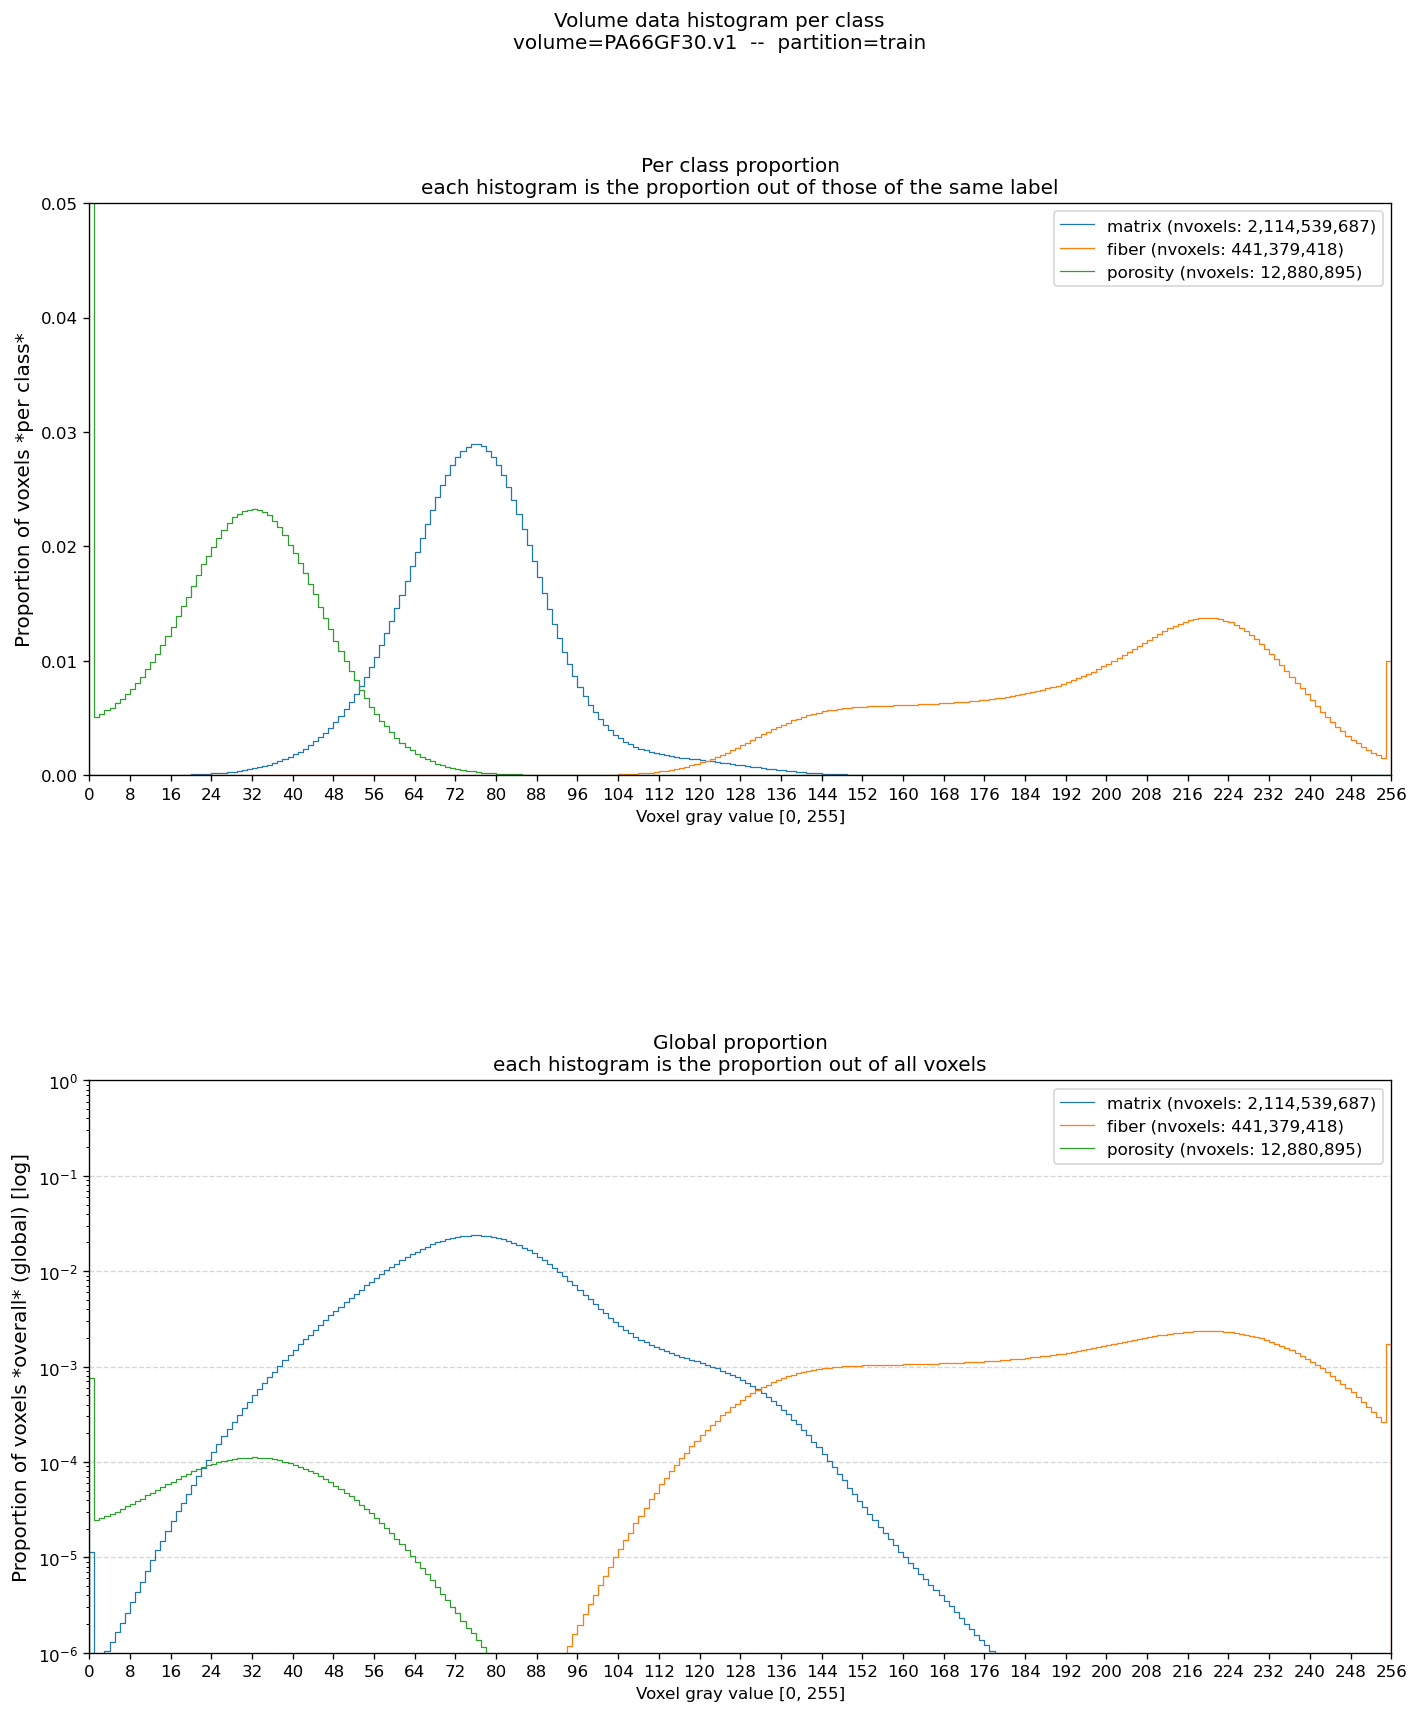

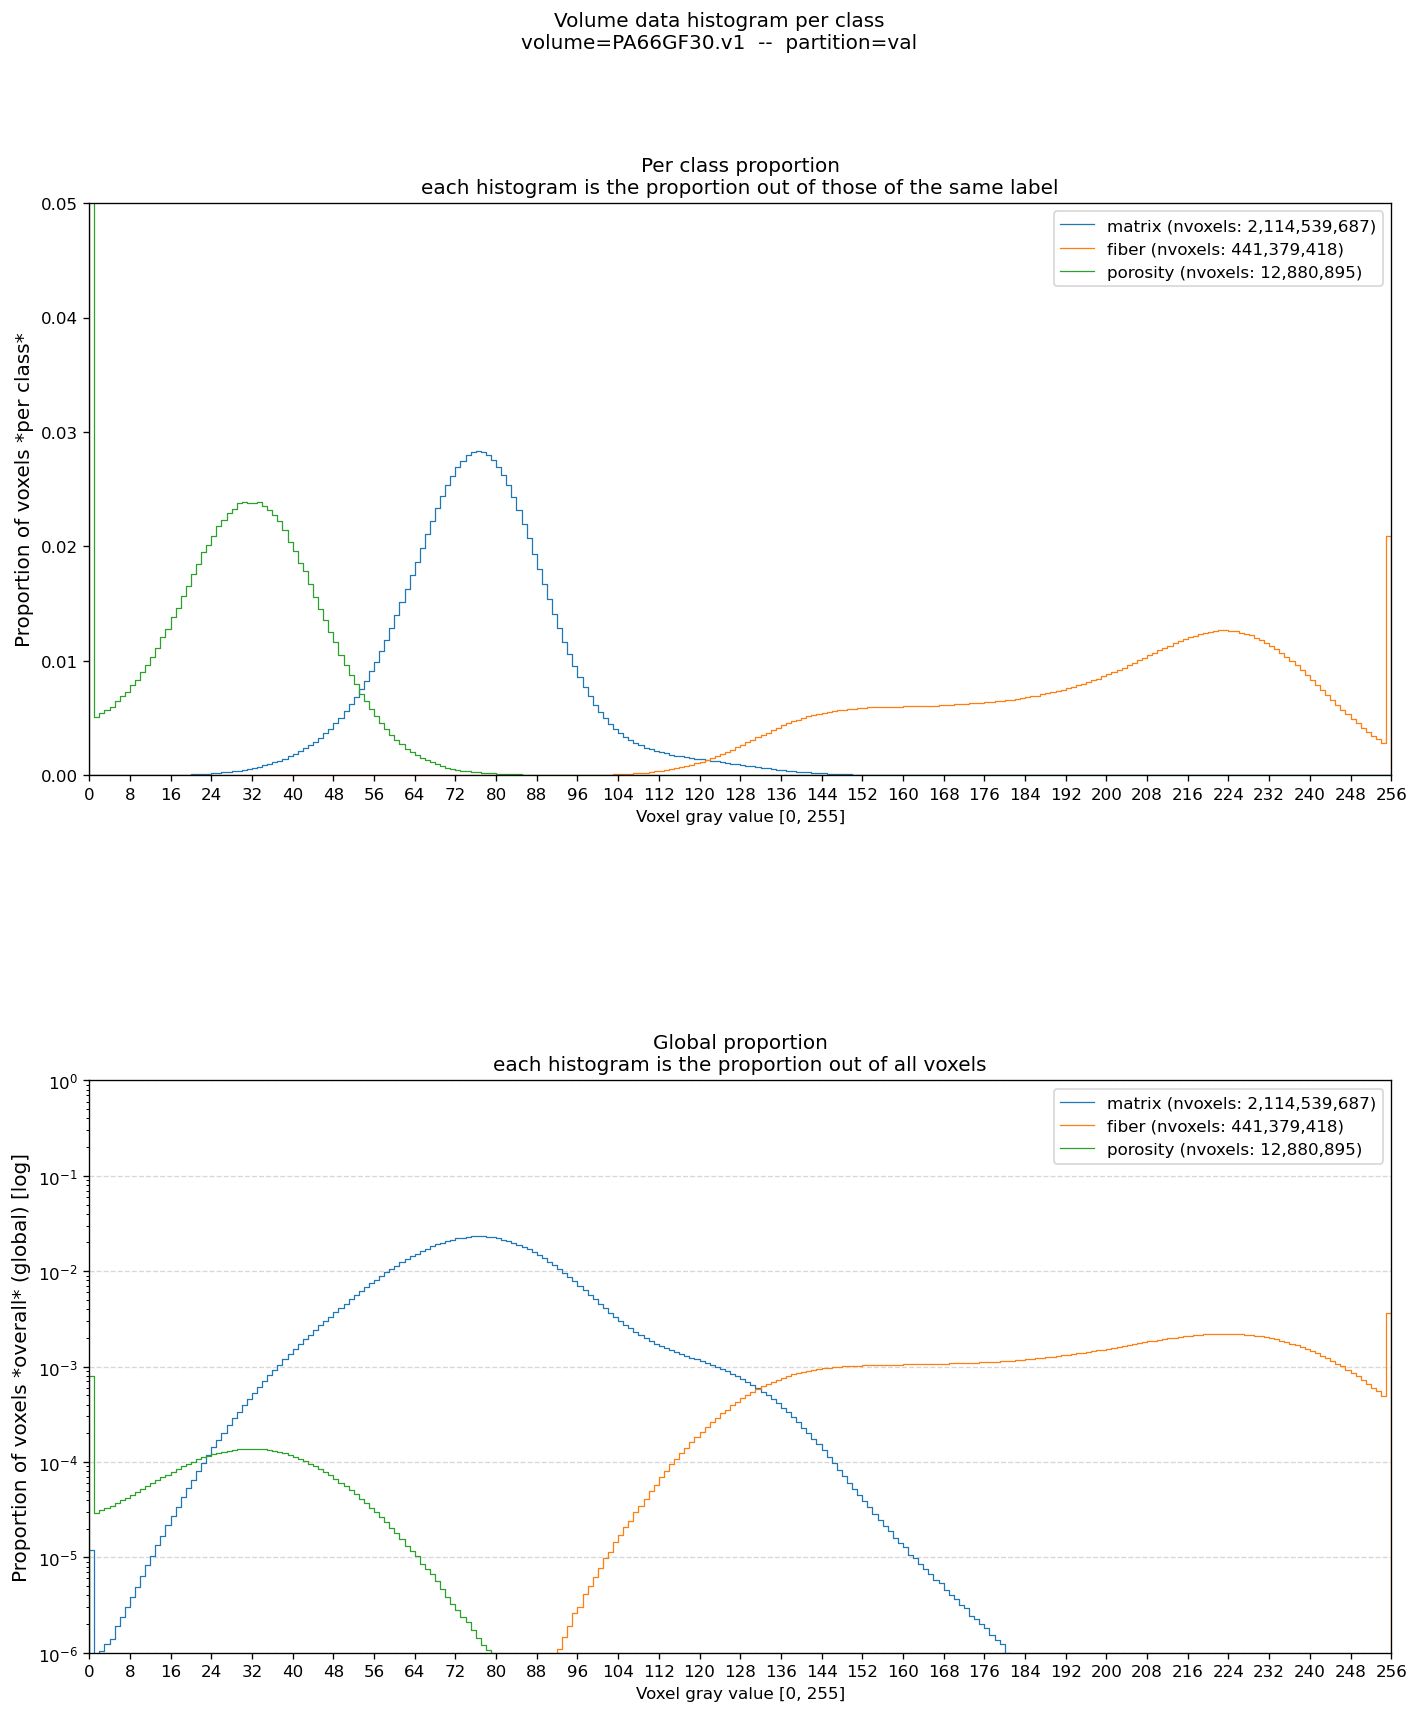

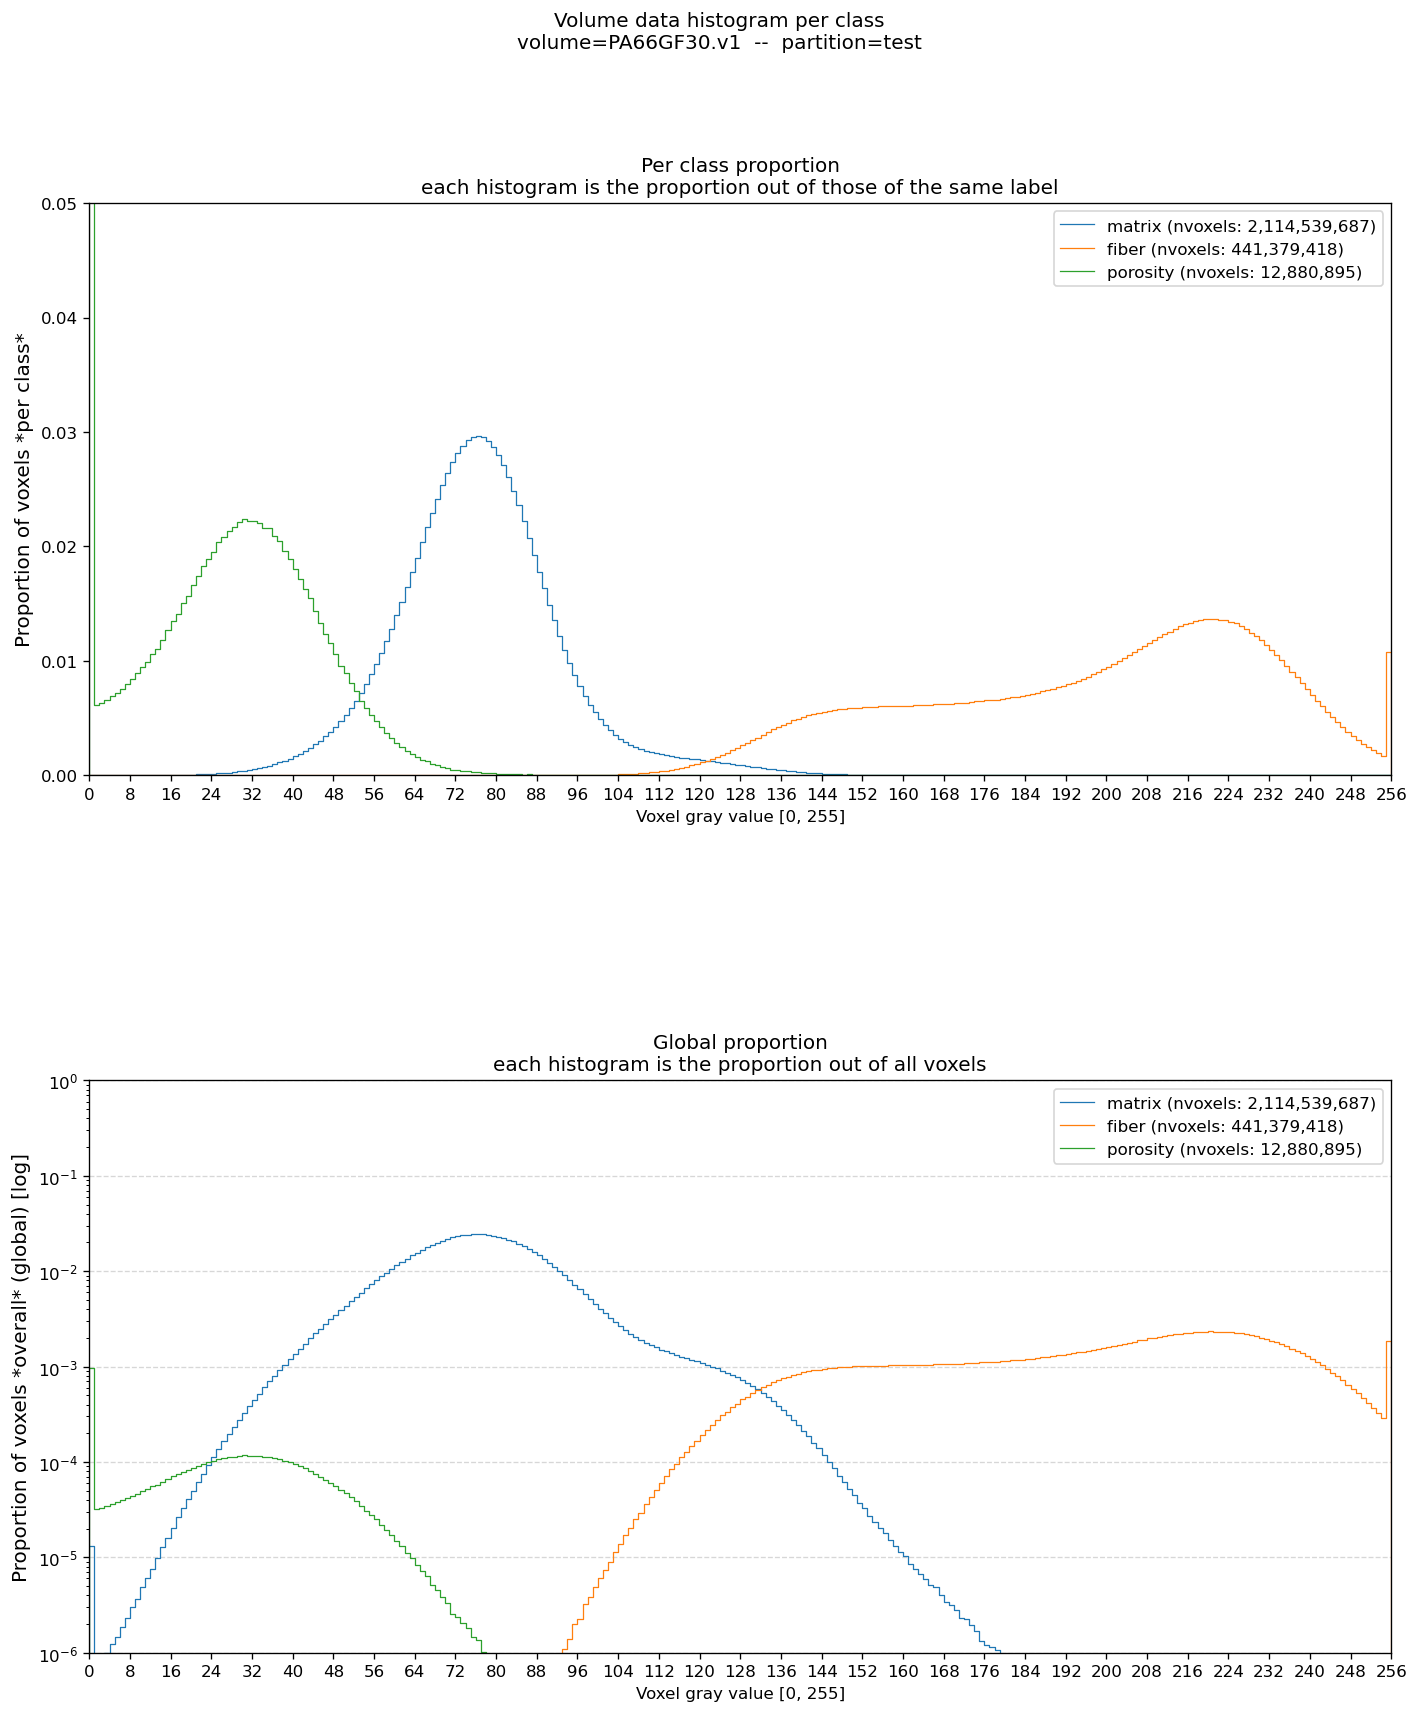

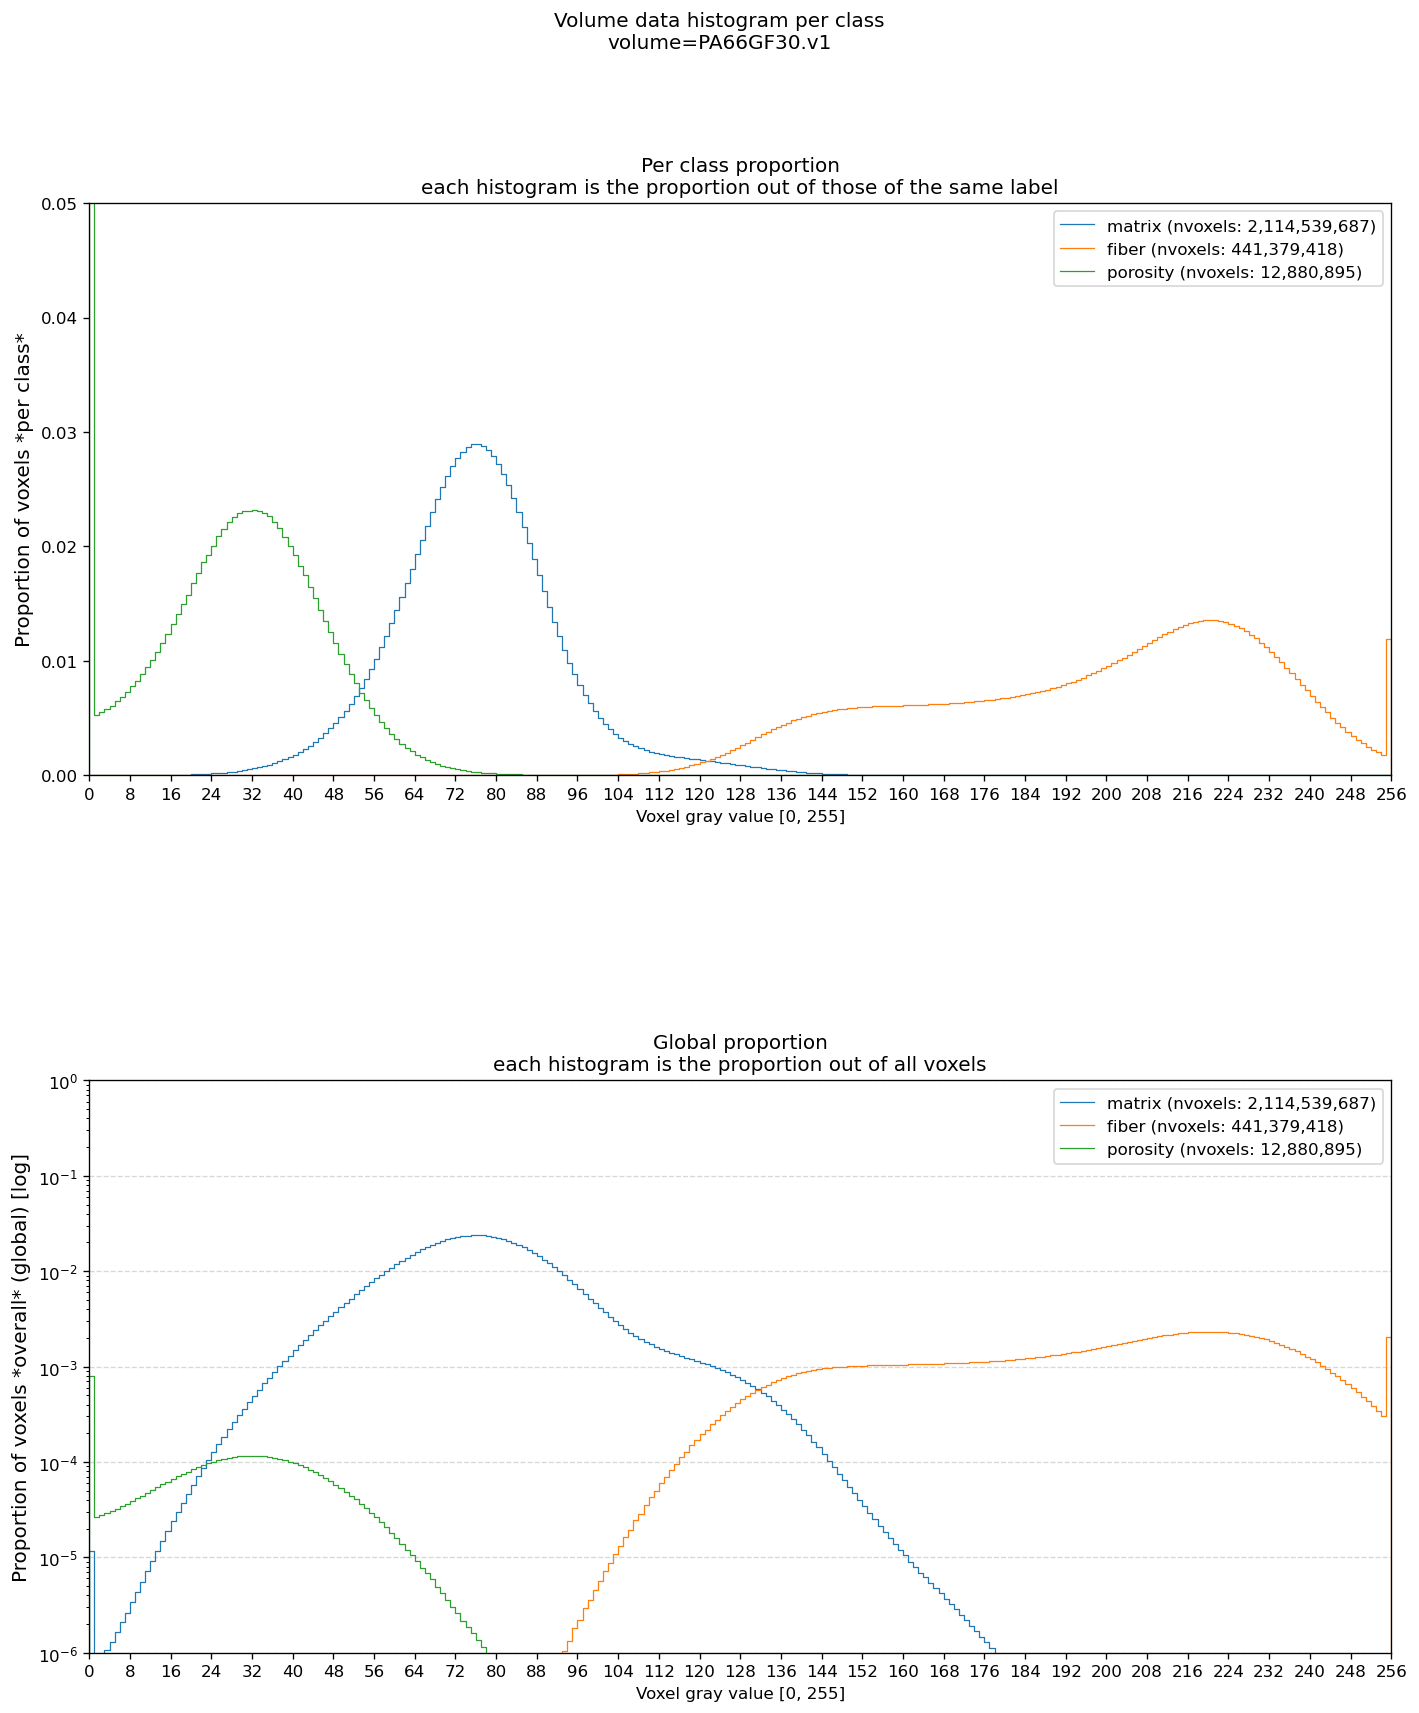

In [94]:
for partition_alias in hists_per_label_norm.keys():
    
    hist_per_label_normed_global_ = hists_per_label_global_norm[partition_alias]
    hist_per_label_normed_ = hists_per_label_norm[partition_alias]
    
    fig, axs = plt.subplots(
        nrows := 2, ncols := 1, figsize=(ncols * 1.75 * (sz := 8), nrows * sz), dpi=(dpi := 120),
        gridspec_kw=dict(hspace=sz / 15)
    )

    display = viz.VoxelValueHistogramPerClassDisplay(
        
        volume_name=f"{volume.fullname}" + ("" if partition_alias is None else f"  --  partition={partition_alias}"),

        bins=hist_bins.tolist(),
        
        values_per_label=hist_per_label_normed_.tolist(),
        values_per_label_global_proportion=hist_per_label_normed_global_.tolist(),
        
        labels_idx=labels_idx,
        line_labels={
            idx: get_line_label_with_nvoxels(idx) for idx in labels_idx
        },
        
    ).plot(axs)
    axs[0].set_ylim(top=.05)
    
    logger.info(f"Saving figure {(figname := display.title + '.png')=}")
    display.fig_.savefig(
        fname=figs_dir / figname,
        format="png",
        metadata=display.metadata,
    )

# Physical metrics